<a href="https://colab.research.google.com/github/LamineGith/PyTorch/blob/main/Working_with_the_FMNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with the FMNIST dataset

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes (0, 1 ... 9). Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

## Labels

| Label | Description |      | Label | Description |
|-------|-------------|      |-------|-------------|
| 0 | T-shirt/top |          | 5 | Sandal |
| 1 | Trouser |              | 6 | Shirt |
| 2 | Pullover |             | 7 | Sport hoe |
| 3 | Dress |                | 8 | Bag |
| 4 | Coat |                 | 9 | Ankle boot | 






In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



**Model build**

When building the model, we have to choose number of nodes. 
For the input nodes, we have 784 because we have 28x28 image size and when flattened it give 784. So the input layer is not changeable. Same as the output layer where we have 10 nodes corresponding to the classes. 

In [3]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    #x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

## Choosing the loss function

**Some loss function for problems types**

|Problem type | Last-layer activation | Loss functions |
| ----------- | ---------------------| ----------------|
| Binary classification | Sigmoid | Binary Crossentrophy |
| Multiclass, single-label classification | Softmax | Categorical crossentrophy|
| Multiclass, multilabel classification | Sigmoid | Binary Crossentrophy |
| Regression to arbitrary values | None | MSE |
| Regression to values between 0 and 1 | Sigmoid | MSE or Binary Crossentrophy |

Here we are using a **Multiclass, single-label classification** because in FMNIST we have 10 classes and each image have just one calss on it. So we can between to Loss functions (CrossentropyLoss and NLLLoss). But by using the **nn.NLLLoss()** we have to specify the **log_softmax()** function at the end of the neural network in the forward function. This because the log_softmax is compute in the NLLLoss function. Check the document for information.  

In [14]:
from torch import optim

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 0.30225591094636206
Training loss: 0.297815013716597
Training loss: 0.2937765993686246


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

images, labels = next(iter(testloader))

test_image_id = 45
img = images[test_image_id].view(1, 784) 

with torch.no_grad():
    logps = model(img)

<BarContainer object of 10 artists>

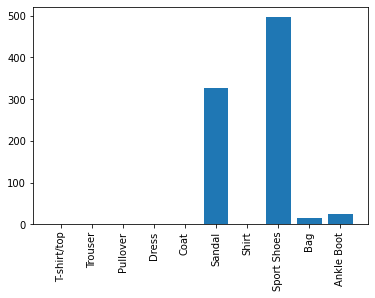

In [19]:
ps = torch.exp(logps)
nps = ps.numpy()[0]
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

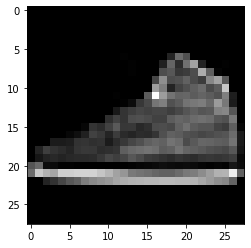

In [20]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')